# Multi-Model TestBook

## Imports

In [1]:
# Imports
import os
# MUST be set before importing any PyTorch/CUDA modules
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import torch
# Configure PyTorch for full determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import seaborn as sns
import pandas as pd
from torchvision import datasets, transforms, models
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchmetrics import Accuracy, F1Score, Precision, Recall
from torchvision.transforms import v2
from tqdm import tqdm
import time
import re

## ViT Branch

### Dataset

In [2]:
# Enhanced Data Preparation with Stratified Splitting
class FireDataset(pl.LightningDataModule):
    def __init__(self, data_dir, augmented_dir,
                 batch_size=32, num_workers=4, train_augmented_multiplicity=4,
                 regenerate=False):
        """
        Custom PyTorch Lightning DataModule for fire detection dataset.

        Args:
            data_dir: Root directory containing original image dataset
            augmented_dir: Directory to save processed images
            batch_size: Number of samples per batch
            num_workers: Parallel threads for data loading
            train_augmented_multiplicity: Multiplier for training data augmentation
            regenerate: Force regeneration of augmented dataset
        """
        super().__init__()
        self.data_dir = data_dir
        self.augmented_dir = augmented_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_augmented_multiplicity = train_augmented_multiplicity
        self.regenerate = regenerate
        self.classes = None
        self.transform = None
        self.augment = None

    def setup(self, stage=None):
        """Prepares datasets and saves augmented images"""
        # Define transforms
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.augment = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Load base dataset
        base_dataset = datasets.ImageFolder(root=self.data_dir, transform=None)
        self.classes = base_dataset.classes
        targets = [s[1] for s in base_dataset.samples]

        # Create splits
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        train_idx, test_idx = next(skf.split(np.zeros(len(targets)), targets))
        val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)

        # Save augmented datasets
        self._save_augmented_dataset(base_dataset, train_idx, val_idx, test_idx)

        # Create datasets from saved images
        self.train_dataset = datasets.ImageFolder(
            root=os.path.join(self.augmented_dir, "train"),
            transform=self.transform  # Only standard transform for saved augmented images
        )
        self.val_dataset = datasets.ImageFolder(
            root=os.path.join(self.augmented_dir, "val"),
            transform=self.transform
        )
        self.test_dataset = datasets.ImageFolder(
            root=os.path.join(self.augmented_dir, "test"),
            transform=self.transform
        )

    def _save_augmented_dataset(self, base_dataset, train_idx, val_idx, test_idx):
        """Saves processed images to filesystem"""
        # Create output directories
        splits = {
            "train": (train_idx, self.augment, self.train_augmented_multiplicity),
            "val": (val_idx, self.transform, 1),
            "test": (test_idx, self.transform, 1)
        }

        # Check if regeneration is needed
        if not self.regenerate and all(os.path.exists(os.path.join(self.augmented_dir, split)) for split in splits):
            print("Using existing augmented dataset")
            return

        print("Generating and saving augmented dataset...")
        for split_name, (indices, transform, multiplicity) in splits.items():
            split_dir = os.path.join(self.augmented_dir, split_name)
            for class_name in self.classes:
                os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

            for idx in indices:
                img, label = base_dataset[idx]
                class_name = self.classes[label]

                for aug_idx in range(multiplicity):
                    # Apply transformations
                    transformed_img = transform(img)

                    # Convert back to PIL for saving
                    img_pil = self._tensor_to_pil(transformed_img)

                    # Save with unique filename
                    original_name = os.path.splitext(os.path.basename(base_dataset.samples[idx][0]))[0]
                    save_path = os.path.join(split_dir, class_name, f"{original_name}_aug{aug_idx}.jpg")
                    img_pil.save(save_path)

    def _tensor_to_pil(self, tensor):
        """Converts normalized tensor back to PIL Image"""
        # Reverse normalization
        inverse_norm = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
        tensor = inverse_norm(tensor)
        tensor = torch.clamp(tensor, 0, 1)
        tensor = tensor.mul(255).byte()
        return transforms.ToPILImage()(tensor.cpu())

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers
        )

### ViT Model

In [2]:
# Vision Transformer (ViT) Feature Extractor with Classification Head
class FireFeatureExtractorViT(pl.LightningModule):
    def __init__(self, config=None):
        """
        Custom Vision Transformer model for fire detection with feature extraction capability.

        Args:
            config: Configuration dictionary with hyperparameters. Defaults to empty dict.
        """
        super().__init__()
        self.config = config or {}
        self.save_hyperparameters(config)  # Save config for checkpointing

        # Initialize with pretrained weights if specified, otherwise random initialization
        weights = ViT_B_16_Weights.IMAGENET1K_V1 if self.config.get("pretrained", True) else None
        self.vit = vit_b_16(weights=weights)

        # Freeze backbone parameters if requested (transfer learning)
        if self.config.get("freeze_backbone", True):
            for param in self.vit.parameters():
                param.requires_grad = False

        # Replace classification head with identity to output raw features (768-dim)
        self.vit.heads = nn.Identity()

        # Custom classification head for binary fire detection
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),  # Feature compression layer
            nn.ReLU(),            # Activation for non-linearity
            nn.BatchNorm1d(256),  # Normalization for stability
            nn.Dropout(self.config.get("dropout_rate", 0.5)),  # Regularization
            nn.Linear(256, 1)     # Binary classification output (fire/no-fire)
        )

        # Loss function with class weighting to handle imbalanced datasets
        self.criterion = nn.BCEWithLogitsLoss(
            pos_weight=torch.tensor(self.config.get("pos_weight", 1.0))
        )

        # Accuracy metrics for different phases
        self.train_acc = Accuracy(task='binary')
        self.val_acc = Accuracy(task='binary')
        self.test_acc = Accuracy(task='binary')

    def forward(self, x):
        """Feature extraction pass - returns 768-dimensional embeddings"""
        return self.vit(x)

    def classify(self, x):
        """Full classification pass (features + classifier head)"""
        features = self.vit(x)  # Extract visual features
        return self.classifier(features).squeeze(1)  # Remove extra dimension

    def configure_optimizers(self):
        """Configure optimizer and learning rate scheduler"""
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.config.get("lr", 1e-4),                # Default learning rate
            weight_decay=self.config.get("weight_decay", 1e-4)  # L2 regularization
        )

        # Learning rate scheduler that reduces when validation accuracy plateaus
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',     # Monitor validation accuracy (maximize)
            factor=0.5,     # Reduce LR by half when triggered
            patience=3,     # Wait 3 epochs without improvement
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_acc",  # Watch validation accuracy
                "frequency": 1         # Check every epoch
            }
        }

    def training_step(self, batch, batch_idx):
        """Single training step with loss calculation and metrics logging"""
        images, labels = batch
        labels = labels.float()  # Convert to float for BCE loss

        # Forward pass through classifier
        outputs = self.classify(images)
        loss = self.criterion(outputs, labels)

        # Convert logits to binary predictions (threshold=0.5)
        preds = torch.sigmoid(outputs) > 0.5
        self.train_acc(preds, labels)  # Update accuracy metric

        # Log training metrics (step-level loss, epoch-level accuracy)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """Single validation step with metrics calculation"""
        images, labels = batch
        labels = labels.float()

        # Forward pass
        outputs = self.classify(images)
        loss = self.criterion(outputs, labels)

        # Calculate accuracy
        preds = torch.sigmoid(outputs) > 0.5
        self.val_acc(preds, labels)

        # Log validation metrics (epoch-level only)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", self.val_acc, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        """Single test step for final evaluation"""
        images, labels = batch
        labels = labels.float()

        # Forward pass
        outputs = self.classify(images)
        loss = self.criterion(outputs, labels)

        # Calculate accuracy
        preds = torch.sigmoid(outputs) > 0.5
        self.test_acc(preds, labels)

        # Log test metrics
        self.log("test_loss", loss, on_epoch=True)
        self.log("test_acc", self.test_acc, on_epoch=True)

        return loss

### Training

In [12]:
# Training Function
def train_feature_extractor(num_epochs):
    """
    Trains the fire feature extractor model end-to-end.

    Args:
        num_epochs: Number of training epochs

    Returns:
        model: Trained feature extractor model
        trainer: PyTorch Lightning trainer object
        data: Data module used for training
    """
    # Initialize data module with default batch size
    data = FireDataset(
        data_dir="dataset/raw/RGB",
        augmented_dir="dataset/vit",  # Use saved augmented images
        batch_size=32,
        regenerate=False,  # Set to True to regenerate images
        train_augmented_multiplicity=5
    )
    data.setup()  # Prepare datasets and transformations

    # Calculate class imbalance weight for positive samples
    # Example: [non-fire_count, fire_count] - replace with actual counts
    class_counts = [1000, 200]  # Example: [negative_class, positive_class]
    pos_weight = class_counts[0] / class_counts[1]  # weight = negative_count / positive_count

    # Model configuration parameters
    config = {
        "lr": 1e-4,               # Learning rate
        "weight_decay": 1e-4,      # L2 regularization strength
        "freeze_backbone": True,   # Freeze ViT weights during training
        "pretrained": True,        # Use pretrained ViT weights
        "dropout_rate": 0.5,       # Dropout probability in classifier
        "pos_weight": pos_weight   # Class imbalance compensation
    }

    # Initialize model with configuration
    model = FireFeatureExtractorViT(config)

    # Model checkpoint callback - saves best model based on validation accuracy
    checkpoint = ModelCheckpoint(
        monitor="val_acc",         # Metric to monitor
        mode="max",                # Maximize validation accuracy
        save_top_k=1,              # Save only the best model
        filename="best_feature_extractor"  # Checkpoint filename
    )

    # Create PyTorch Lightning trainer
    trainer = pl.Trainer(
        max_epochs=num_epochs,    # Training duration
        callbacks=[checkpoint],    # Attach checkpoint callback
        accelerator="auto",        # Automatically select hardware (GPU/CPU)
        devices=1,                # Use single device
        log_every_n_steps=10,     # Log metrics every 10 batches
    )

    # Train the model
    trainer.fit(model, data)

    # Evaluate on test set after training
    test_result = trainer.test(model, dataloaders=data.test_dataloader())
    print(f"Test Accuracy: {test_result[0]['test_acc']:.4f}")

    return model, trainer, data

# Save Feature Extractor
def save_feature_extractor(trainer, path="feature_extractor.pth"):
    """
    Saves the trained feature extractor as a Lightning checkpoint.

    Preserves model weights, hyperparameters, and optimizer state.

    Args:
        trainer: Trainer instance containing the model
        path: Output file path for checkpoint
    """
    # Save entire model state including metadata and optimizer
    trainer.save_checkpoint(path)
    print(f"Full Lightning checkpoint saved to {path}")

# Feature Extraction Function
def extract_features(model, dataloader):
    """
    Extracts feature vectors from images using the trained model.

    Args:
        model: Trained feature extractor model
        dataloader: DataLoader providing image batches

    Returns:
        features: 2D array of extracted features [n_samples, 768]
        labels: 1D array of corresponding labels
    """
    model.eval()  # Set model to evaluation mode
    features = []  # Storage for feature vectors
    labels = []    # Storage for corresponding labels

    with torch.no_grad():  # Disable gradient calculation
        for images, batch_labels in dataloader:
            # Move images to same device as model (GPU/CPU)
            images = images.to(model.device)

            # Extract features (768-dimensional vectors)
            batch_features = model(images)

            # Store results (move to CPU for numpy conversion)
            features.append(batch_features.cpu().numpy())
            labels.append(batch_labels.numpy())

    # Combine all batches into single arrays
    return np.concatenate(features), np.concatenate(labels)

In [13]:
# --- TRAINING PIPELINE EXECUTION ---
# Clear GPU memory cache to avoid out-of-memory errors
torch.cuda.empty_cache()

# Start performance timer
start = time.time()

# Step 1: Train the feature extractor model
print("Training feature extractor...")
trained_model, trainer, data = train_feature_extractor(num_epochs=40)

# Step 2: Save the trained model for future use
save_feature_extractor(trainer, "Saved_Features/ViT_fire_feature_extractor.pth")

# Step 3: Load the feature extractor (without classifier head)
print("\nLoading feature extractor for inference...")
# Initialize model with default configuration
feature_extractor = FireFeatureExtractorViT()
# Load weights while ignoring classifier parameters (strict=False)
feature_extractor.load_state_dict(
    torch.load("Saved_Features/ViT_fire_feature_extractor.pth"),
    strict=False  # Required since we're discarding the classifier
)
feature_extractor.eval()  # Set to evaluation mode

# Step 4: Extract feature vectors from training data
print("\nExtracting features from training dataset...")
train_features, train_labels = extract_features(
    feature_extractor,
    data.train_dataloader()
)
print(f"Extracted {len(train_features)} feature vectors (768-dim each)")

# Step 5: Demonstrate feature usage for downstream models
print("\nFeatures ready for transfer learning or multi-model systems:")
print(f"Feature vector shape: {train_features[0].shape}")  # Should be (768,)
print(f"Sample feature (first 10 values): {train_features[0][:10]}...")

# Calculate and display execution time
time_taken = time.time() - start
print(f"\nTotal Execution Time: {time_taken:.2f} seconds ({time_taken / 60:.2f} minutes)")

Training feature extractor...
Generating and saving augmented dataset...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/carbs/Desktop/Projects/ViT-Based_ForestFire/REPO/forest_fire_detection/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | vit        | VisionTransformer | 85.8 M | train
1 | classifier | Sequential        | 197 K  | train
2 | criterion  | BCEWithLogitsL

Using existing augmented dataset
Epoch 0: 100%|██████████| 81/81 [02:19<00:00,  0.58it/s, v_num=21, train_loss_step=0.378]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1:  16%|█▌        | 13/81 [00:25<02:13,  0.51it/s, v_num=21, train_loss_step=0.229, val_loss=0.277, val_acc=0.953, train_loss_epoch=0.472, train_acc=0.843]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

## CNN Branch

### Dataset

In [55]:
# Custom Dataset Class for Processed Thermal Images
class ProcessedThermalDataset(Dataset):
    """
    PyTorch Dataset for loading processed thermal images from directory structure.

    Args:
        root_dir: Root directory containing class subdirectories
        transform: Composition of image transformations to apply
    """
    def __init__(self, root_dir, transform=None):
        self.dataset = datasets.ImageFolder(root=root_dir, transform=transform)
        self.classes = self.dataset.classes
        self.class_to_idx = self.dataset.class_to_idx
        self.samples = self.dataset.samples
        self.targets = self.dataset.targets

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

# Data Module for Thermal Image Processing and Augmentation Saving
class ThermalDataModule:
    def __init__(self,
                 raw_data_dir='dataset/raw/thermal',
                 processed_dir='dataset/thermal_processed',
                 train_augmented_multiplicity=4,
                 batch_size=16,
                 regenerate=False):
        """
        Handles thermal data processing, augmentation, and saving.

        Args:
            raw_data_dir: Directory with 'fire' and 'no_fire' subdirectories
            processed_dir: Where to save processed images
            train_augmented_multiplicity: Number of augmented versions per training image
            batch_size: Batch size for dataloaders
            regenerate: Force regeneration of processed images
        """
        self.raw_data_dir = raw_data_dir
        self.processed_dir = processed_dir
        self.train_augmented_multiplicity = train_augmented_multiplicity
        self.batch_size = batch_size
        self.regenerate = regenerate
        self.classes = ['no_fire', 'fire']

        # Define transforms - ensure output is 1-channel grayscale
        self.augment_transform = v2.Compose([
            v2.RandomResizedCrop(size=(224, 224), antialias=True),
            v2.RandomHorizontalFlip(p=0.5),
            v2.GaussianBlur(kernel_size=3, sigma=(0.5, 2.0)),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Grayscale(num_output_channels=1),  # Convert to grayscale
            v2.Normalize(mean=[0.5], std=[0.5]),
        ])

        self.test_transform = v2.Compose([
            v2.Resize(size=(224, 224), antialias=True),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Grayscale(num_output_channels=1),  # Convert to grayscale
            v2.Normalize(mean=[0.5], std=[0.5]),
        ])

        # Loading transform (applied when loading saved images)
        self.loading_transform = v2.Compose([
            v2.Grayscale(num_output_channels=1),  # Ensure grayscale conversion
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.5], std=[0.5])
        ])

        # Create datasets after processing
        self.setup()

    def _denormalize(self, tensor):
        """Convert normalized tensor back to PIL Image"""
        inverse_norm = v2.Normalize(
            mean=[-0.5/0.5],
            std=[1/0.5]
        )
        tensor = inverse_norm(tensor)
        tensor = torch.clamp(tensor, 0, 1)
        tensor = tensor.mul(255).byte()
        return v2.ToPILImage()(tensor.cpu())

    def _save_augmented_images(self):
        """Process and save augmented images to filesystem"""
        fire_dir = os.path.join(self.raw_data_dir, 'fire')
        non_fire_dir = os.path.join(self.raw_data_dir, 'no_fire')

        # Collect image paths and labels
        image_paths = []
        labels = []

        # Load fire images (label=1)
        if os.path.isdir(fire_dir):
            for filename in os.listdir(fire_dir):
                if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                    image_paths.append(os.path.join(fire_dir, filename))
                    labels.append(1)

        # Load non-fire images (label=0)
        if os.path.isdir(non_fire_dir):
            for filename in os.listdir(non_fire_dir):
                if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                    image_paths.append(os.path.join(non_fire_dir, filename))
                    labels.append(0)

        if not image_paths:
            raise ValueError("No images found in raw data directories")

        # Print raw class distribution
        print("\nRaw Data Class Distribution:")
        print(f"Total images: {len(image_paths)}")
        print(f"Fire images: {labels.count(1)} ({labels.count(1)/len(labels):.1%})")
        print(f"No-fire images: {labels.count(0)} ({labels.count(0)/len(labels):.1%})")

        # Verify we have both classes
        if labels.count(1) == 0 or labels.count(0) == 0:
            raise ValueError("Dataset missing one class! Cannot perform stratified split")

        # Create 70/15/15 split with no overlapping images
        # Step 1: Split into train (70%) and temp (30%)
        train_img, temp_img, train_lbl, temp_lbl = train_test_split(
            image_paths, labels,
            test_size=0.3,
            random_state=42,
            stratify=labels
        )

        # Step 2: Split temp into val (15%) and test (15%)
        val_img, test_img, val_lbl, test_lbl = train_test_split(
            temp_img, temp_lbl,
            test_size=0.5,
            random_state=42,
            stratify=temp_lbl
        )

        # Create directory structure
        splits = {
            'train': (train_img, train_lbl, self.train_augmented_multiplicity),
            'val': (val_img, val_lbl, 1),
            'test': (test_img, test_lbl, 1)
        }

        # Verify no overlapping images
        train_set = set(train_img)
        val_set = set(val_img)
        test_set = set(test_img)

        assert train_set.isdisjoint(val_set), "Train and validation sets overlap!"
        assert train_set.isdisjoint(test_set), "Train and test sets overlap!"
        assert val_set.isdisjoint(test_set), "Validation and test sets overlap!"

        # Print distribution statistics
        print("\nDataset Split Distribution:")
        print(f"Total images: {len(image_paths)}")
        print(f"Training images: {len(train_img)} ({len(train_img)/len(image_paths):.1%})")
        print(f"Validation images: {len(val_img)} ({len(val_img)/len(image_paths):.1%})")
        print(f"Test images: {len(test_img)} ({len(test_img)/len(image_paths):.1%})")

        print("\nClass Distribution in Splits:")
        print("Training - Fire:", train_lbl.count(1), f"({train_lbl.count(1)/len(train_lbl):.1%})",
              "No Fire:", train_lbl.count(0), f"({train_lbl.count(0)/len(train_lbl):.1%})")
        print("Validation - Fire:", val_lbl.count(1), f"({val_lbl.count(1)/len(val_lbl):.1%})",
              "No Fire:", val_lbl.count(0), f"({val_lbl.count(0)/len(val_lbl):.1%})")
        print("Test - Fire:", test_lbl.count(1), f"({test_lbl.count(1)/len(test_lbl):.1%})",
              "No Fire:", test_lbl.count(0), f"({test_lbl.count(0)/len(test_lbl):.1%})")

        # CRITICAL: Ensure validation set has fire images
        if val_lbl.count(1) == 0:
            raise RuntimeError("Validation set has ZERO fire images! Check data distribution")

        for split_name, (img_paths, lbls, multiplicity) in splits.items():
            split_dir = os.path.join(self.processed_dir, split_name)
            for class_name in self.classes:
                class_dir = os.path.join(split_dir, class_name)
                os.makedirs(class_dir, exist_ok=True)

            for img_path, label in zip(img_paths, lbls):
                img = Image.open(img_path)
                # Convert to RGB first to ensure consistent processing
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                class_name = self.classes[label]

                for aug_idx in range(multiplicity):
                    # Apply transforms
                    if split_name == 'train':
                        transformed = self.augment_transform(img)
                    else:
                        transformed = self.test_transform(img)

                    # Convert back to PIL and save
                    img_pil = self._denormalize(transformed)
                    fname = os.path.basename(img_path)
                    base, ext = os.path.splitext(fname)
                    save_path = os.path.join(
                        split_dir,
                        class_name,
                        f"{base}_aug{aug_idx}{ext}"
                    )
                    img_pil.save(save_path)

        print("Augmented dataset saved successfully!")

    def setup(self):
        """Prepare datasets by processing and saving images if needed"""
        # Regenerate images if requested or not exists
        if self.regenerate or not os.path.exists(self.processed_dir):
            print("Generating and saving augmented dataset...")
            self._save_augmented_images()

        # Create datasets from saved images
        self.train_dataset = ProcessedThermalDataset(
            os.path.join(self.processed_dir, 'train'),
            transform=self.loading_transform
        )
        self.val_dataset = ProcessedThermalDataset(
            os.path.join(self.processed_dir, 'val'),
            transform=self.loading_transform
        )
        self.test_dataset = ProcessedThermalDataset(
            os.path.join(self.processed_dir, 'test'),
            transform=self.loading_transform
        )

        # Verify image channels
        img, label = self.train_dataset[0]
        print(f"\nFirst training image shape: {img.shape}")
        print(f"First training label: {label} ({self.classes[label]})")

        # Verify validation set content
        val_img, val_label = self.val_dataset[0]
        print(f"First validation image shape: {val_img.shape}")
        print(f"First validation label: {val_label} ({self.classes[val_label]})")

        # Print class distribution in validation set
        val_labels = [label for _, label in self.val_dataset]
        print(f"\nValidation Set Class Distribution:")
        print(f"Fire images: {sum(1 for l in val_labels if l == 1)}")
        print(f"No-fire images: {sum(1 for l in val_labels if l == 0)}")

        # Create dataloaders
        self.train_dataloaderCNN = DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True
        )
        self.val_dataloaderCNN = DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
        self.test_dataloaderCNN = DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )

        # Print dataset stats
        print(f"\nFinal Dataset Sizes:")
        print(f" - Training: {len(self.train_dataset)} samples")
        print(f" - Validation: {len(self.val_dataset)} samples")
        print(f" - Testing: {len(self.test_dataset)} samples")
        print(f" - Classes: {self.train_dataset.classes}")

### CNN Model

In [3]:
class FireFeatureExtractorCNN(nn.Module):
    def __init__(self, feature_dim=1280):
        super(FireFeatureExtractorCNN, self).__init__()
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Modify first convolution layer for grayscale input
        original_first_conv = self.base_model.features[0][0]
        self.base_model.features[0][0] = nn.Conv2d(
            1,  # Single channel input (thermal images)
            original_first_conv.out_channels,
            kernel_size=original_first_conv.kernel_size,
            stride=original_first_conv.stride,
            padding=original_first_conv.padding,
            bias=False
        )

        # Initialize with averaged weights
        with torch.no_grad():
            # Average across RGB channels: [out, 3, k, k] -> [out, 1, k, k]
            new_weight = original_first_conv.weight.mean(dim=1, keepdim=True)
            self.base_model.features[0][0].weight.copy_(new_weight)

        self.features = self.base_model.features
        self.feature_processor = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
        self.feature_refiner = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )
        self.classifier = nn.Linear(512, 1)

    def forward(self, x, return_features=False):
        # Ensure input is grayscale (1 channel)
        if x.shape[1] == 3:
            # Convert to grayscale using weighted average
            x = 0.2989 * x[:, 0] + 0.5870 * x[:, 1] + 0.1140 * x[:, 2]
            x = x.unsqueeze(1)  # Add channel dimension

        x = self.features(x)
        x = self.feature_processor(x)
        features = self.feature_refiner(x)
        logits = self.classifier(features)

        if return_features:
            return logits, features
        return logits


### Training

In [53]:
def train_model(model, train_dataloader, val_dataloader, num_epochs=10, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Training on: {device}")

    # Calculate class weights for imbalance
    train_targets = train_dataloader.dataset.targets
    class_counts = [np.sum(np.array(train_targets) == 0),  # no_fire
                   np.sum(np.array(train_targets) == 1)]   # fire

    print(f"\nTraining Set Class Distribution:")
    print(f" - No-fire: {class_counts[0]} samples ({class_counts[0]/len(train_targets):.1%})")
    print(f" - Fire: {class_counts[1]} samples ({class_counts[1]/len(train_targets):.1%})")

    # Calculate pos_weight for BCEWithLogitsLoss
    if class_counts[1] > 0:  # Prevent division by zero
        pos_weight = torch.tensor([class_counts[0] / class_counts[1]]).to(device)
    else:
        pos_weight = torch.tensor([1.0]).to(device)
        print("Warning: No fire samples in training set!")

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    print(f"Using positive weight: {pos_weight.item():.2f} for fire class")

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',  # Monitor validation accuracy
        factor=0.5,
        patience=3
    )

    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0.0
    best_model_state = None

    # Diagnostic: Check first batch performance
    print("\nRunning diagnostic on first batch...")
    model.eval()
    with torch.no_grad():
        first_batch = next(iter(train_dataloader))
        images, labels = first_batch
        images, labels = images.to(device), labels.to(device).float()

        print(f"First batch image shape: {images.shape}")
        print(f"First 5 labels: {labels[:5].cpu().numpy()}")

        outputs = model(images)
        initial_loss = criterion(outputs.squeeze(), labels)
        preds = torch.sigmoid(outputs) > 0.5
        initial_acc = (preds.squeeze() == labels).float().mean()

        print(f"Initial loss (before training): {initial_loss.item():.4f}")
        print(f"Initial accuracy (before training): {initial_acc.item():.4f}")
        print(f"First 5 predictions: {preds[:5].squeeze().cpu().numpy()}")

    # Add gradient clipping
    max_grad_norm = 1.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            running_loss += loss.item() * images.size(0)

            # Calculate training accuracy
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds.squeeze() == labels).sum().item()
            total += labels.size(0)
            train_acc = correct / total

            progress_bar.set_postfix({
                'loss': loss.item(),
                'acc': train_acc
            })

            # Log first batch of first epoch in detail
            if epoch == 0 and batch_idx == 0:
                print("\nDetailed first batch analysis:")
                print(f"Labels: {labels[:10].cpu().numpy()}")
                print(f"Raw outputs: {outputs[:10].squeeze().detach().cpu().numpy()}")
                print(f"Predictions: {preds[:10].squeeze().cpu().numpy()}")

                # Check model parameters
                print("\nModel parameter checks:")
                for name, param in model.named_parameters():
                    if param.requires_grad and "classifier" not in name:
                        print(f"{name}: mean={param.data.mean().item():.6f}, std={param.data.std().item():.6f}")
                        if param.grad is not None:
                            print(f"  grad: mean={param.grad.mean().item():.6f}, std={param.grad.std().item():.6f}")

        epoch_loss = running_loss / len(train_dataloader.dataset)
        train_losses.append(epoch_loss)
        epoch_train_acc = correct / total

        # Validation
        val_loss, val_acc = validate_model(model, val_dataloader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Update learning rate based on validation accuracy
        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            print(f"New best model with val_acc: {val_acc:.4f}")

        print(f'\nEpoch {epoch+1}/{num_epochs} Summary:')
        print(f' - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_train_acc:.4f}')
        print(f' - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        print(f' - LR: {optimizer.param_groups[0]["lr"]:.2e}')

        # Early stopping if validation accuracy is perfect
        if val_acc >= 1.0 and epoch > 0:
            print("Warning: Perfect validation accuracy detected. Stopping early for investigation.")
            break

    # Plotting and saving
    plot_training_history(train_losses, val_losses, val_accuracies)
    torch.save(best_model_state, 'Saved_Features/CNN_best_model_weights.pth')
    print("Saved best model weights to 'Saved_Features/CNN_best_model_weights.pth'")

    # Load best weights into model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    else:
        print("Warning: No best model state found. Using final epoch model.")

    return model

def validate_model(model, val_dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    fire_correct = 0
    fire_total = 0
    nofire_correct = 0
    nofire_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            running_loss += loss.item() * images.size(0)

            preds = torch.sigmoid(outputs) > 0.5

            # Track class-wise accuracy
            for i in range(len(labels)):
                if labels[i] == 1:
                    fire_total += 1
                    fire_correct += int(preds[i].item() == labels[i].item())
                else:
                    nofire_total += 1
                    nofire_correct += int(preds[i].item() == labels[i].item())

            correct += (preds.squeeze() == labels).sum().item()
            total += labels.size(0)

            # Store for analysis - convert to flat arrays
            all_preds.append(preds.cpu().numpy().flatten())
            all_labels.append(labels.cpu().numpy().flatten())

    if total == 0:
        return 0, 0  # Prevent division by zero

    val_loss = running_loss / total
    val_acc = correct / total

    # Print detailed report
    print("\nValidation Set Analysis:")
    print(f"Total samples: {total}")
    print(f"Fire samples: {fire_total} ({fire_total/total:.1%})")
    print(f"No-fire samples: {nofire_total} ({nofire_total/total:.1%})")
    print(f"Fire accuracy: {fire_correct/max(1, fire_total):.1%} ({fire_correct}/{fire_total})")
    print(f"No-fire accuracy: {nofire_correct/max(1, nofire_total):.1%} ({nofire_correct}/{nofire_total})")

    # Combine all batches into single arrays
    if all_preds:
        all_preds_flat = np.concatenate(all_preds)
        all_labels_flat = np.concatenate(all_labels)
    else:
        all_preds_flat = np.array([])
        all_labels_flat = np.array([])

    # Print prediction distribution
    if len(all_preds_flat) > 0:
        print(f"Prediction distribution: {np.mean(all_preds_flat):.1%} fire predictions")

        # Print first 10 actual predictions
        print("\nFirst 10 validation predictions:")
        for i in range(min(10, len(all_preds_flat))):
            pred = all_preds_flat[i]
            label = all_labels_flat[i]
            status = "✅" if pred == label else "❌"
            print(f"{status} Sample {i+1}: Predicted {'Fire' if pred else 'No-fire'}, Actual {'Fire' if label else 'No-fire'}")

    return val_loss, val_acc

def test_model(model, test_dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device).float()
            outputs, features = model(images, return_features=True)

            all_features.append(features.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds.squeeze() == labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    all_features = np.concatenate(all_features)
    all_labels = np.concatenate(all_labels)

    print(f'Test Accuracy: {test_acc:.4f}')
    return test_acc, all_features, all_labels

def plot_training_history(train_losses, val_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Val Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()
    plt.title('Validation Accuracy')

    plt.tight_layout()
    os.makedirs('Figures', exist_ok=True)
    plt.savefig('Figures/CNN_training_history.png')
    plt.close()
    print("Saved training history plot to 'Figures/CNN_training_history.png'")

def save_feature_extractor_cnn(model, path="Saved_Features/CNN_feature_extractor.pth"):
    state_dict = model.state_dict()
    keys_to_remove = [k for k in state_dict.keys() if k.startswith('classifier')]
    for k in keys_to_remove:
        del state_dict[k]
    torch.save(state_dict, path)
    print(f"CNN feature extractor saved to {path} (without classifier)")

In [56]:
# --- FEATURE EXTRACTOR TRAINING PIPELINE ---
# Clear GPU memory cache to prevent out-of-memory errors
torch.cuda.empty_cache()

# Start performance timer
start = time.time()

# Initialize data module with augmentation saving
print("Processing thermal data and saving augmented images...")
data_module = ThermalDataModule(
    raw_data_dir='dataset/raw/thermal',
    processed_dir='dataset/thermal_processed',
    train_augmented_multiplicity=4,
    batch_size=16,
    regenerate=True  # Set to True to recreate dataset
)

# Step 1: Initialize the CNN-based feature extractor model
print("Initializing feature extractor model...")
model = FireFeatureExtractorCNN()

# Step 2: Train the model
print("\nStarting model training...")
trained_model = train_model(
    model,
    data_module.train_dataloaderCNN,
    data_module.val_dataloaderCNN,
    num_epochs=15,
    lr=0.0001
)

# Step 3: Evaluate on test set and extract features
print("\nEvaluating model on test set...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_acc, test_features, test_labels = test_model(
    trained_model,
    data_module.test_dataloaderCNN,
    device
)
print(f"Test Accuracy: {test_acc:.4f}")

# Step 4: Save feature extractor without classification head
print("\nSaving feature extractor weights...")
save_feature_extractor_cnn(trained_model, "Saved_Features/CNN_fire_feature_extractor.pth")

# Step 5: Analyze extracted features
print("\nFeature Extraction Summary:")
print(f"Extracted {len(test_features)} feature vectors")
print(f"Feature vector shape: {test_features[0].shape}")
print("Sample feature (first 10 values):", test_features[0][:10])
print("...")

# Step 6: Save features for downstream multi-model system
print("\nSaving features for ensemble model training...")
os.makedirs('Saved_Features', exist_ok=True)
np.save('Saved_Features/CNN_test_features.npy', test_features)
np.save('Saved_Features/CNN_test_labels.npy', test_labels)
print("Features and labels saved in Saved_Features/ directory")

# Calculate and display execution time
time_taken = time.time() - start
print(f"\nTotal Execution Time: {time_taken:.2f} seconds ({time_taken / 60:.2f} minutes)")

Processing thermal data and saving augmented images...
Generating and saving augmented dataset...

Raw Data Class Distribution:
Total images: 533
Fire images: 417 (78.2%)
No-fire images: 116 (21.8%)

📊 Dataset Split Distribution:
Total images: 533
Training images: 373 (70.0%)
Validation images: 80 (15.0%)
Test images: 80 (15.0%)

Class Distribution in Splits:
Training - Fire: 292 (78.3%) No Fire: 81 (21.7%)
Validation - Fire: 63 (78.8%) No Fire: 17 (21.2%)
Test - Fire: 62 (77.5%) No Fire: 18 (22.5%)
Augmented dataset saved successfully!

First training image shape: torch.Size([1, 224, 224])
First training label: 0 (no_fire)
First validation image shape: torch.Size([1, 224, 224])
First validation label: 0 (no_fire)

Validation Set Class Distribution:
Fire images: 17
No-fire images: 63

Final Dataset Sizes:
 - Training: 1492 samples
 - Validation: 80 samples
 - Testing: 80 samples
 - Classes: ['fire', 'no_fire']
Initializing feature extractor model...

Starting model training...
Training

Epoch 1/15 [Train]:   1%|          | 1/94 [00:00<00:32,  2.85it/s, loss=1.15, acc=0.688]


Detailed first batch analysis:
Labels: [1. 0. 1. 0. 1. 0. 1. 0. 0. 0.]
Raw outputs: [ 0.13272625 -0.0490072  -0.04258956 -0.000714   -0.04495082 -0.00431211
 -0.1083767  -0.09835131  0.15155178 -0.02629899]
Predictions: [ True False False False False False False False  True False]

Model parameter checks:
base_model.features.0.0.weight: mean=-0.000880, std=0.178995
  grad: mean=-0.009961, std=0.048500
base_model.features.0.1.weight: mean=0.198515, std=0.151526
  grad: mean=-0.001921, std=0.006943
base_model.features.0.1.bias: mean=0.218089, std=0.378694
  grad: mean=-0.002319, std=0.007581
base_model.features.1.conv.0.0.weight: mean=0.006950, std=0.476703
  grad: mean=-0.001690, std=0.011335
base_model.features.1.conv.0.1.weight: mean=0.365765, std=0.329835
  grad: mean=-0.000266, std=0.007158
base_model.features.1.conv.0.1.bias: mean=0.446404, std=0.554804
  grad: mean=-0.000553, std=0.001503
base_model.features.1.conv.1.weight: mean=0.005115, std=0.222593
  grad: mean=0.000286, std=

Epoch 1/15 [Train]: 100%|██████████| 94/94 [00:20<00:00,  4.54it/s, loss=0.0505, acc=0.974]  



Validation Set Analysis:
Total samples: 80
Fire samples: 17 (21.2%)
No-fire samples: 63 (78.8%)
Fire accuracy: 100.0% (17/17)
No-fire accuracy: 100.0% (63/63)
Prediction distribution: 21.2% fire predictions

First 10 validation predictions:
✅ Sample 1: Predicted No-fire, Actual No-fire
✅ Sample 2: Predicted No-fire, Actual No-fire
✅ Sample 3: Predicted No-fire, Actual No-fire
✅ Sample 4: Predicted No-fire, Actual No-fire
✅ Sample 5: Predicted No-fire, Actual No-fire
✅ Sample 6: Predicted No-fire, Actual No-fire
✅ Sample 7: Predicted No-fire, Actual No-fire
✅ Sample 8: Predicted No-fire, Actual No-fire
✅ Sample 9: Predicted No-fire, Actual No-fire
✅ Sample 10: Predicted No-fire, Actual No-fire
New best model with val_acc: 1.0000

Epoch 1/15 Summary:
 - Train Loss: 0.1375, Train Acc: 0.9739
 - Val Loss: 0.0006, Val Acc: 1.0000
 - LR: 1.00e-04


Epoch 2/15 [Train]: 100%|██████████| 94/94 [00:22<00:00,  4.27it/s, loss=0.0522, acc=0.998]  



Validation Set Analysis:
Total samples: 80
Fire samples: 17 (21.2%)
No-fire samples: 63 (78.8%)
Fire accuracy: 100.0% (17/17)
No-fire accuracy: 100.0% (63/63)
Prediction distribution: 21.2% fire predictions

First 10 validation predictions:
✅ Sample 1: Predicted No-fire, Actual No-fire
✅ Sample 2: Predicted No-fire, Actual No-fire
✅ Sample 3: Predicted No-fire, Actual No-fire
✅ Sample 4: Predicted No-fire, Actual No-fire
✅ Sample 5: Predicted No-fire, Actual No-fire
✅ Sample 6: Predicted No-fire, Actual No-fire
✅ Sample 7: Predicted No-fire, Actual No-fire
✅ Sample 8: Predicted No-fire, Actual No-fire
✅ Sample 9: Predicted No-fire, Actual No-fire
✅ Sample 10: Predicted No-fire, Actual No-fire

Epoch 2/15 Summary:
 - Train Loss: 0.0132, Train Acc: 0.9980
 - Val Loss: 0.0001, Val Acc: 1.0000
 - LR: 1.00e-04
Saved training history plot to 'Figures/CNN_training_history.png'
Saved best model weights to 'Saved_Features/CNN_best_model_weights.pth'

Evaluating model on test set...
Test Accura

In [34]:
# --- TEST SET FEATURE ANALYSIS ---
# Print dataset statistics after feature extraction
print(f"Number of test samples: {len(test_labels)}")       # Total test instances processed
print(f"Feature matrix shape: {test_features.shape}")      # Dimensions: [samples x features]
print(f"Feature dimension: {test_features.shape[1]}")      # Size of each feature vector

Number of test samples: 80
Feature matrix shape: (80, 512)
Feature dimension: 512


In [47]:
def predict_new_image(model, image_path, transform, device):
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        prob = torch.sigmoid(output).item()
        return "Fire" if prob < 0.5 else "No-fire", prob

# Usage:
test_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.Grayscale(num_output_channels=1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5], std=[0.5])
])

prediction, confidence = predict_new_image(
    trained_model,
    "dataset/raw/thermal/fire/00008.JPG",
    test_transform,
    device
)
print(f"Prediction: {prediction} with confidence: {confidence:.2f}")

Prediction: Fire with confidence: 0.00


## NN classifer

### Dataset

In [4]:
# Dataset for multi-modal inputs (ViT + CNN)
class DualInputDataset(Dataset):
    def __init__(self, vit_image_paths, cnn_image_paths, labels, vit_transform, cnn_transform):
        """
        Dataset for dual-input models (RGB + thermal)

        Args:
            vit_image_paths: List of paths to RGB images (ViT input)
            cnn_image_paths: List of paths to thermal images (CNN input)
            labels: List of corresponding labels
            vit_transform: Transform pipeline for ViT images
            cnn_transform: Transform pipeline for CNN images
        """
        self.vit_image_paths = vit_image_paths
        self.cnn_image_paths = cnn_image_paths
        self.labels = labels
        self.vit_transform = vit_transform
        self.cnn_transform = cnn_transform

        # Validate data alignment
        if len(vit_image_paths) != len(cnn_image_paths) or len(vit_image_paths) != len(labels):
            raise ValueError("Input lengths mismatch: ViT paths, CNN paths and labels must be equal")

    def __len__(self):
        """Returns total number of samples"""
        return len(self.labels)

    def __getitem__(self, idx):
        """Loads and transforms image pair, returns (vit_input, cnn_input, label)"""
        # Process RGB image for ViT
        vit_img = Image.open(self.vit_image_paths[idx]).convert('RGB')
        vit_tensor = self.vit_transform(vit_img)

        # Process thermal image for CNN
        cnn_img = Image.open(self.cnn_image_paths[idx])
        cnn_tensor = self.cnn_transform(cnn_img)

        # Convert label to tensor
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        return vit_tensor, cnn_tensor, label

In [5]:
def denormalize_tensor(tensor, mean, std):
    """Denormalize tensor using mean and std"""
    if tensor.dim() == 4:  # batch dimension
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return tensor
    else:
        return tensor * torch.tensor(std).view(-1, 1, 1) + torch.tensor(mean).view(-1, 1, 1)

def generate_augmented_images(image_paths, transform, output_dir, modality, num_copies):
    """
    Generate and save augmented images to disk
    Returns list of paths to augmented images
    """
    os.makedirs(output_dir, exist_ok=True)
    new_paths = []

    for path in image_paths:
        img = Image.open(path)
        base_name = os.path.splitext(os.path.basename(path))[0]

        for j in range(num_copies):
            # Apply transformation
            tensor = transform(img)

            # Denormalize for saving
            if modality == 'RGB':
                denorm_tensor = denormalize_tensor(
                    tensor,
                    [0.485, 0.456, 0.406],
                    [0.229, 0.224, 0.225]
                )
            elif modality == 'thermal':
                denorm_tensor = denormalize_tensor(
                    tensor,
                    [0.5],
                    [0.5]
                )
                denorm_tensor = denorm_tensor.squeeze(0)  # Remove channel dim
                pil_img = transforms.ToPILImage()(denorm_tensor.cpu())

            # Convert to PIL and save
            if modality == 'RGB':
                pil_img = transforms.ToPILImage()(denorm_tensor)
            else:
                # Handle grayscale separately
                pil_img = transforms.ToPILImage()(denorm_tensor.squeeze(0))

            new_filename = f"{base_name}_aug{j}.jpg"
            new_path = os.path.join(output_dir, new_filename)
            pil_img.save(new_path)
            new_paths.append(new_path)

    return new_paths

In [6]:
# Prepare multimodal datasets for fusion model training
def prepare_fusion_data(vit_fire_dir, vit_non_fire_dir, cnn_fire_dir, cnn_non_fire_dir):
    print(f"\n{'='*50}")
    print("Preparing multimodal fusion dataset")
    print(f"ViT fire (RGB) directory: {vit_fire_dir}")
    print(f"ViT non-fire (RGB) directory: {vit_non_fire_dir}")
    print(f"CNN fire (thermal) directory: {cnn_fire_dir}")
    print(f"CNN non-fire (thermal) directory: {cnn_non_fire_dir}")

    # Normalizes filenames for matching across modalities
    def get_base_name(filename):
        base = os.path.splitext(filename)[0]  # Remove extension
        base = re.sub(r'^(RGB_|THERMAL_|IMG_|DSC_)', '', base)  # Remove prefixes
        return re.sub(r'[^a-zA-Z0-9]', '', base).lower()  # Standardize format

    # Process RGB images for ViT model
    vit_mapping = {}
    # Process fire RGB images
    if os.path.isdir(vit_fire_dir):
        print(f"Processing ViT fire images")
        for filename in os.listdir(vit_fire_dir):
            if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue
            base_name = get_base_name(filename)
            vit_mapping[base_name] = {"path": os.path.join(vit_fire_dir, filename), "label": 1}

    # Process non-fire RGB images
    if os.path.isdir(vit_non_fire_dir):
        print(f"Processing ViT non-fire images")
        for filename in os.listdir(vit_non_fire_dir):
            if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue
            base_name = get_base_name(filename)
            vit_mapping[base_name] = {"path": os.path.join(vit_non_fire_dir, filename), "label": 0}

    print(f"ViT images found: {len(vit_mapping)}")

    # Process thermal images for CNN model
    cnn_mapping = {}
    # Process fire thermal images
    if os.path.isdir(cnn_fire_dir):
        print(f"Processing CNN fire images")
        for filename in os.listdir(cnn_fire_dir):
            if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue
            base_name = get_base_name(filename)
            cnn_mapping[base_name] = {"path": os.path.join(cnn_fire_dir, filename), "label": 1}

    # Process non-fire thermal images
    if os.path.isdir(cnn_non_fire_dir):
        print(f"Processing CNN non-fire images")
        for filename in os.listdir(cnn_non_fire_dir):
            if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue
            base_name = get_base_name(filename)
            cnn_mapping[base_name] = {"path": os.path.join(cnn_non_fire_dir, filename), "label": 0}

    print(f"CNN images found: {len(cnn_mapping)}")

    # Match image pairs across modalities
    matched_pairs = []
    for key in set(vit_mapping.keys()) & set(cnn_mapping.keys()):  # Intersection of keys
        vit_data = vit_mapping[key]
        cnn_data = cnn_mapping[key]

        # Verify consistent labeling
        if vit_data["label"] != cnn_data["label"]:
            print(f"Label mismatch for {key}: ViT={vit_data['label']}, CNN={cnn_data['label']}")
            continue

        matched_pairs.append((vit_data["path"], cnn_data["path"], vit_data["label"]))

    print(f"Total matched pairs: {len(matched_pairs)}")

    # Analyze class distribution
    fire_pairs = [p for p in matched_pairs if p[2] == 1]
    non_fire_pairs = [p for p in matched_pairs if p[2] == 0]
    print(f"Fire pairs: {len(fire_pairs)}, Non-fire pairs: {len(non_fire_pairs)}")

    # Handle insufficient data scenarios
    if not matched_pairs:
        # Diagnostic output for debugging
        print("\nSample ViT keys:", list(vit_mapping.keys())[:5])
        print("Sample CNN keys:", list(cnn_mapping.keys())[:5])
        raise ValueError("No matching pairs found. Check filename patterns and directories.")

    # Balance classes if both present
    if fire_pairs and non_fire_pairs:
        n_per_class = min(len(fire_pairs), len(non_fire_pairs))
        all_pairs = fire_pairs[:n_per_class] + non_fire_pairs[:n_per_class]
        print(f"Balanced dataset: {n_per_class} per class")
    else:
        all_pairs = matched_pairs
        print("Using all available pairs (single class)")

    # Shuffle dataset
    np.random.shuffle(all_pairs)
    vit_paths, cnn_paths, labels = zip(*all_pairs)  # Unzip pairs

    # Stratified split into train/val/test (70/15/15)
    train_idx, test_idx = train_test_split(
        range(len(labels)),
        test_size=0.7,
        random_state=42,
        stratify=labels
    )
    test_idx, val_idx = train_test_split(
        test_idx,
        test_size=0.5,
        random_state=42,
        stratify=[labels[i] for i in test_idx]
    )

    # Create split indices
    vit_train = [vit_paths[i] for i in train_idx]
    cnn_train = [cnn_paths[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]

    vit_val = [vit_paths[i] for i in val_idx]
    cnn_val = [cnn_paths[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]

    vit_test = [vit_paths[i] for i in test_idx]
    cnn_test = [cnn_paths[i] for i in test_idx]
    test_labels = [labels[i] for i in test_idx]

    # Dataset statistics
    print(f"\nDataset splits:")
    print(f"Train: {len(vit_train)} pairs")
    print(f"Validation: {len(vit_val)} pairs")
    print(f"Test: {len(vit_test)} pairs")

    # Transformation pipelines
    # ViT (RGB) transforms
    vit_train_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    vit_eval_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # CNN (thermal) transforms
    cnn_train_transform = v2.Compose([
        v2.RandomResizedCrop(size=(224, 224)),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Grayscale(num_output_channels=1),
        v2.Normalize(mean=[0.5], std=[0.5]),
    ])

    cnn_eval_transform = v2.Compose([
        v2.Resize(size=(224, 224)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Grayscale(num_output_channels=1),
        v2.Normalize(mean=[0.5], std=[0.5]),
    ])

    print("\nGenerating augmented training images...")
    num_aug_copies = 10  # Generate num augmented copies per original image

    # Create output directories
    processed_rgb_dir = "dataset/processed/RGB"
    processed_thermal_dir = "dataset/processed/thermal"

    # Generate augmented RGB images
    aug_rgb_paths = generate_augmented_images(
        vit_train,
        vit_train_transform,
        processed_rgb_dir,
        'RGB',
        num_aug_copies
    )

    # Generate augmented thermal images
    aug_thermal_paths = generate_augmented_images(
        cnn_train,
        cnn_train_transform,
        processed_thermal_dir,
        'thermal',
        num_aug_copies
    )

    # Combine original and augmented paths
    vit_train_combined = vit_train + aug_rgb_paths
    cnn_train_combined = cnn_train + aug_thermal_paths
    train_labels_combined = train_labels + train_labels * num_aug_copies

    # Verify new sizes
    print(f"\nAugmented dataset sizes:")
    print(f"Original RGB training images: {len(vit_train)}")
    print(f"Original thermal training images: {len(cnn_train)}")
    print(f"Augmented RGB images: {len(aug_rgb_paths)}")
    print(f"Augmented thermal images: {len(aug_thermal_paths)}")
    print(f"RGB Combined training set: {len(vit_train_combined)}")
    print(f"Thermal Combined training set: {len(cnn_train_combined)}")
    print(f"Combined training set: {len(train_labels_combined)} pairs")

    # Create new transforms for training (only normalization since augmentation is pre-generated)
    vit_train_transform_final = transforms.Compose([
        transforms.Resize((224, 224)),  # Ensure correct size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    cnn_train_transform_final = v2.Compose([
        v2.Resize((224, 224)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Grayscale(num_output_channels=1),
        v2.Normalize(mean=[0.5], std=[0.5]),
    ])

    # Create datasets
    train_dataset = DualInputDataset(
        vit_train_combined,
        cnn_train_combined,
        train_labels_combined,
        vit_train_transform_final,
        cnn_train_transform_final
    )

    val_dataset = DualInputDataset(
        vit_val,
        cnn_val,
        val_labels,
        vit_eval_transform,
        cnn_eval_transform
    )

    test_dataset = DualInputDataset(
        vit_test,
        cnn_test,
        test_labels,
        vit_eval_transform,
        cnn_eval_transform
    )

    # Create dataloaders
    batch_size = 16
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=4
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=4
    )

    print(f"\nTrain dataset sizes: {len(train_dataset)} = {len(train_dataloader)} batches")
    print(f"Val dataset sizes: {len(val_dataset)} = {len(val_dataloader)} batches")
    print(f"Test dataset sizes: {len(test_dataset)} = {len(test_dataloader)} batches")

    return train_dataloader, val_dataloader, test_dataloader

#### Create Dataset

In [7]:
# Dataset paths
vit_fire_dir = "dataset/raw/RGB/fire"
vit_non_fire_dir = "dataset/raw/RGB/no_fire"
cnn_fire_dir = "dataset/raw/thermal/fire"
cnn_non_fire_dir = "dataset/raw/thermal/no_fire"

# Prepare Dataset
print("\nPreparing fusion datasets...")
train_loader, val_loader, test_loader = prepare_fusion_data(
    vit_fire_dir, vit_non_fire_dir, cnn_fire_dir, cnn_non_fire_dir
)


Preparing fusion datasets...

Preparing multimodal fusion dataset
ViT fire (RGB) directory: dataset/raw/RGB/fire
ViT non-fire (RGB) directory: dataset/raw/RGB/no_fire
CNN fire (thermal) directory: dataset/raw/thermal/fire
CNN non-fire (thermal) directory: dataset/raw/thermal/no_fire
Processing ViT fire images
Processing ViT non-fire images
ViT images found: 529
Processing CNN fire images
Processing CNN non-fire images
CNN images found: 417
Total matched pairs: 417
Fire pairs: 301, Non-fire pairs: 116
Balanced dataset: 116 per class

Dataset splits:
Train: 69 pairs
Validation: 82 pairs
Test: 81 pairs

Generating augmented training images...

Augmented dataset sizes:
Original RGB training images: 69
Original thermal training images: 69
Augmented RGB images: 690
Augmented thermal images: 690
RGB Combined training set: 759
Thermal Combined training set: 759
Combined training set: 759 pairs

Train dataset sizes: 759 = 48 batches
Val dataset sizes: 82 = 6 batches
Test dataset sizes: 81 = 6 

### NN Model

In [8]:
# Fusion Model combining ViT and CNN features
class FusionModel(pl.LightningModule):
    def __init__(self, vit_extractor, cnn_extractor, config=None, visuals=True):
        """
        Multimodal fusion model combining ViT (RGB) and CNN (thermal) features.

        Args:
            vit_extractor: Pretrained ViT feature extractor
            cnn_extractor: Pretrained CNN feature extractor
            config: Configuration dictionary for hyperparameters
            visuals: Enable advanced visualization metrics
        """
        super().__init__()
        # Configuration setup
        default_config = {
            "lr": 1e-3,                # Learning rate
            "weight_decay": 1e-4,      # L2 regularization
            "dropout_rate": 0.4,       # Dropout probability
            "hidden_dim": 512,         # Fusion layer dimension
            "pos_weight": 1.0          # Class imbalance weight
        }
        if config:
            default_config.update(config)  # Merge with user config
        self.config = default_config

        # Visualization settings
        self.visuals = visuals
        self.save_hyperparameters(ignore=["vit_extractor", "cnn_extractor"])

        # Feature extractors (frozen)
        self.vit_extractor = vit_extractor
        self.cnn_extractor = cnn_extractor

        # Freeze extractors to preserve learned features
        for param in self.vit_extractor.parameters():
            param.requires_grad = False
        for param in self.cnn_extractor.parameters():
            param.requires_grad = False

        # Fusion classifier network
        self.classifier = nn.Sequential(
            nn.Linear(768 + 512, self.config["hidden_dim"]),  # Combine features
            nn.ReLU(),                                        # Non-linearity
            nn.BatchNorm1d(self.config["hidden_dim"]),        # Stabilization
            nn.Dropout(self.config["dropout_rate"]),          # Regularization
            nn.Linear(self.config["hidden_dim"], 1)           # Binary output
        )

        # Loss function with class weighting
        self.criterion = nn.BCEWithLogitsLoss(
            pos_weight=torch.tensor(self.config["pos_weight"])
        )

        # Core metrics
        self.train_acc = Accuracy(task='binary')
        self.val_acc = Accuracy(task='binary')
        self.test_acc = Accuracy(task='binary')

        self.train_acc_history = []  # Store training accuracy per epoch
        self.val_acc_history = []    # Store validation accuracy per epoch

        # Advanced metrics for visualization
        if self.visuals:
            # F1 Scores
            self.train_f1 = F1Score(task='binary')
            self.val_f1 = F1Score(task='binary')
            self.test_f1 = F1Score(task='binary')

            # Precision metrics
            self.train_precision = Precision(task='binary')
            self.val_precision = Precision(task='binary')
            self.test_precision = Precision(task='binary')

            # Recall metrics
            self.train_recall = Recall(task='binary')
            self.val_recall = Recall(task='binary')
            self.test_recall = Recall(task='binary')

        # Storage for test visualizations
        self.test_preds = []    # Predicted labels
        self.test_targets = []  # Ground truth labels
        self.test_probs = []    # Prediction probabilities

    def forward(self, vit_input, cnn_input):
        """Forward pass through both feature extractors and fusion classifier"""
        # Extract features from both modalities
        vit_features = self.vit_extractor(vit_input)  # RGB features (768-dim)
        _, cnn_features = self.cnn_extractor(cnn_input, return_features=True)  # Thermal features (512-dim)

        # Concatenate features along channel dimension
        combined = torch.cat((vit_features, cnn_features), dim=1)
        return self.classifier(combined).squeeze(1)  # Remove extra dimension

    def training_step(self, batch, batch_idx):
        """Single training step with metrics calculation"""
        vit_imgs, cnn_imgs, labels = batch
        logits = self(vit_imgs, cnn_imgs)  # Forward pass
        loss = self.criterion(logits, labels)  # Compute loss

        # Convert to probabilities and predictions
        probs = torch.sigmoid(logits)
        preds = probs > 0.5  # Threshold at 0.5

        # Update metrics
        self.train_acc(preds, labels)
        if self.visuals:
            self.train_f1(preds, labels)
            self.train_precision(preds, labels)
            self.train_recall(preds, labels)

        # Log metrics
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        if self.visuals:
            self.log("train_f1", self.train_f1, on_step=False, on_epoch=True, prog_bar=True)
            self.log("train_precision", self.train_precision, on_step=False, on_epoch=True)
            self.log("train_recall", self.train_recall, on_step=False, on_epoch=True)

        return loss

    def on_train_epoch_start(self):
        """Reset training metrics at the beginning of each epoch"""
        self.train_acc.reset()
        if self.visuals:
            self.train_f1.reset()
            self.train_precision.reset()
            self.train_recall.reset()

    def on_validation_epoch_start(self):
        """Reset validation metrics at the beginning of each epoch"""
        self.val_acc.reset()
        if self.visuals:
            self.val_f1.reset()
            self.val_precision.reset()
            self.val_recall.reset()

    def validation_step(self, batch, batch_idx):
        """
        Validation step with proper model state handling

        Ensures:
        - Model is in evaluation mode
        - Gradients are disabled for efficiency
        - Metrics are properly synchronized across devices
        """
        # Set model to evaluation mode and disable gradients
        self.eval()
        with torch.no_grad():
            vit_imgs, cnn_imgs, labels = batch
            logits = self(vit_imgs, cnn_imgs)
            loss = self.criterion(logits, labels)
            probs = torch.sigmoid(logits)
            preds = probs > 0.5

        # Update metrics
        self.val_acc(preds, labels)
        if self.visuals:
            self.val_f1(preds, labels)
            self.val_precision(preds, labels)
            self.val_recall(preds, labels)

        # Log metrics with synchronization for distributed training
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("val_acc", self.val_acc, on_epoch=True, prog_bar=True, sync_dist=True)
        if self.visuals:
            self.log("val_f1", self.val_f1, on_epoch=True, prog_bar=True, sync_dist=True)
            self.log("val_precision", self.val_precision, on_epoch=True, sync_dist=True)
            self.log("val_recall", self.val_recall, on_epoch=True, sync_dist=True)

        return loss


    def test_step(self, batch, batch_idx):
        """Test step with metrics and data collection for visualization"""
        vit_imgs, cnn_imgs, labels = batch
        logits = self(vit_imgs, cnn_imgs)
        loss = self.criterion(logits, labels)
        probs = torch.sigmoid(logits)
        preds = probs > 0.5

        # Update metrics
        self.test_acc(preds, labels)
        if self.visuals:
            self.test_f1(preds, labels)
            self.test_precision(preds, labels)
            self.test_recall(preds, labels)

            # Store for visualization
            self.test_preds.extend(preds.cpu().numpy())
            self.test_targets.extend(labels.cpu().numpy())
            self.test_probs.extend(probs.cpu().numpy())

        # Log metrics
        self.log("test_loss", loss, on_epoch=True)
        self.log("test_acc", self.test_acc, on_epoch=True)
        if self.visuals:
            self.log("test_f1", self.test_f1, on_epoch=True)
            self.log("test_precision", self.test_precision, on_epoch=True)
            self.log("test_recall", self.test_recall, on_epoch=True)

        return loss

    def on_train_epoch_end(self):
        """Record training and validation accuracy at epoch end"""
        # Only record if metrics are available (handles incomplete epochs)
        if self.trainer.callback_metrics.get("train_acc") is not None:
            self.train_acc_history.append(self.trainer.callback_metrics["train_acc"].item())
        if self.trainer.callback_metrics.get("val_acc") is not None:
            self.val_acc_history.append(self.trainer.callback_metrics["val_acc"].item())

    def on_train_end(self):
        """Generate accuracy history plot after training completes"""
        if self.visuals and self.train_acc_history and self.val_acc_history:
            self.plot_accuracy_history()

    def plot_accuracy_history(self):
        """Plot training and validation accuracy over epochs"""
        plt.figure(figsize=(10, 6))
        epochs = range(1, len(self.train_acc_history) + 1)

        # Plot training and validation accuracy
        plt.plot(epochs, self.train_acc_history, 'bo-', label='Training Accuracy')
        plt.plot(epochs, self.val_acc_history, 'go-', label='Validation Accuracy')

        # Format plot
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1.05)  # Ensure accuracy range is visible
        plt.legend()
        plt.grid(True)

        # Save and show
        plt.savefig("Figures/accuracy_history.png")
        plt.show()

    def on_test_end(self):
        """Generate evaluation visualizations after testing completes"""
        if self.visuals and self.test_targets:
            self.generate_visualizations()
            # Clear stored data
            self.test_preds = []
            self.test_targets = []
            self.test_probs = []

    def generate_visualizations(self):
        """Create comprehensive evaluation plots and reports"""
        y_true = np.array(self.test_targets)
        y_pred = np.array(self.test_preds)
        y_probs = np.array(self.test_probs)

        # 1. Classification Report
        print("\n" + "="*50)
        print("Classification Report:")
        print(classification_report(y_true, y_pred, target_names=["Non-Fire", "Fire"]))

        # 2. Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Non-Fire', 'Fire'],
                    yticklabels=['Non-Fire', 'Fire'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.savefig("Figures/confusion_matrix.png")
        plt.show()

        # 3. ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig("Figures/roc_curve.png")
        plt.show()

        # 4. Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_true, y_probs)
        avg_precision = np.mean(precision)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2,
                 label=f'Precision-Recall (Avg Precision = {avg_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.savefig("Figures/precision_recall_curve.png")
        plt.show()

        # 5. Probability Distribution
        plt.figure(figsize=(10, 6))
        df = pd.DataFrame({
            'Probability': y_probs,
            'Class': ['Fire' if t == 1 else 'Non-Fire' for t in y_true]
        })
        sns.histplot(
            data=df,
            x='Probability', hue='Class', element='step', stat='density',
            common_norm=False, bins=20, palette=['red', 'green']
        )
        plt.title('Predicted Probability Distribution')
        plt.axvline(0.5, color='black', linestyle='--')
        plt.savefig("Figures/probability_distribution.png")
        plt.show()

    def configure_optimizers(self):
        """Configure optimizer and learning rate scheduler"""
        optimizer = torch.optim.AdamW(
            self.classifier.parameters(),  # Only optimize fusion classifier
            lr=self.config["lr"],
            weight_decay=self.config["weight_decay"]
        )

        # Learning rate scheduler (monitors validation accuracy)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',       # Maximize validation accuracy
            factor=0.5,       # Reduce LR by half
            patience=3,       # Wait 3 epochs without improvement
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_acc",  # Track validation accuracy
                "frequency": 1          # Check every epoch
            }
        }

### Training function

In [9]:
# Training function for multimodal fusion model
def train_fusion_model(vit_extractor, cnn_extractor, train_loader, val_loader, test_loader,
                      max_epochs, config=None, visuals=True):
    """
    End-to-end training pipeline for multimodal fusion model with enhanced validation.

    Args:
        vit_extractor: Pretrained ViT feature extractor
        cnn_extractor: Pretrained CNN feature extractor
        max_epochs: Maximum training epochs
        config: Hyperparameter configuration dictionary
        visuals: Enable advanced evaluation metrics

    Returns:
        model: Trained fusion model
        test_results: Test performance metrics
    """

    # Check Validation set size
    val_size = len(val_loader.dataset)
    print(f"Validation samples: {val_size}")

    # Check class distribution
    all_val_labels = []
    for batch in val_loader:
        # Updated for 4-tuple batches: (vit, cnn, labels, identifiers)
        labels = batch[2]  # Labels are the 3rd element
        all_val_labels.extend(labels.cpu().numpy())

    fire_count = sum(all_val_labels)
    non_fire_count = len(all_val_labels) - fire_count
    print(f"Fire samples: {fire_count} ({fire_count/len(all_val_labels):.1%})")
    print(f"Non-Fire samples: {non_fire_count} ({non_fire_count/len(all_val_labels):.1%})")


    # Initialize fusion model
    print("Initializing fusion model...")
    model = FusionModel(
        vit_extractor=vit_extractor,
        cnn_extractor=cnn_extractor,
        config=config,
        visuals=visuals
    )

    # Validate dataloaders
    print("\nValidating dataloaders:")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader) if val_loader is not None else 0}")
    print(f"Test batches: {len(test_loader)}")

    # Check for empty validation loader
    if val_loader is None or len(val_loader) == 0:
        print("\nWARNING: Validation loader is empty. Switching to test-only mode")
        val_loader = None
        monitor_metric = "train_acc"
        callbacks = []
    else:
        monitor_metric = "val_acc"
        # Configure training callbacks
        callbacks = [
            # Early stopping based on validation accuracy
            pl.callbacks.EarlyStopping(
                monitor=monitor_metric,
                patience=5,
                mode="max",
                verbose=True
            ),
            # Model checkpointing
            pl.callbacks.ModelCheckpoint(
                monitor=monitor_metric,
                mode="max",
                filename="best_fusion_model",
                save_top_k=1,
                save_last=True
            ),
            # Learning rate monitor
            pl.callbacks.LearningRateMonitor(logging_interval='epoch')
        ]

    # Create PyTorch Lightning trainer with validation enhancements
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="auto",        # Automatic hardware selection
        devices="auto",            # Use available devices
        log_every_n_steps=5,       # Log metrics every 5 batches
        callbacks=callbacks,
        enable_progress_bar=True,
        check_val_every_n_epoch=1,  # Validate every single epoch
        num_sanity_val_steps=2,     # Run 2 validation batches before training starts
        deterministic=True,         # Ensure reproducible results
        enable_model_summary=True
    )

    # Train the model with explicit validation loader
    print("\nStarting fusion model training...")
    trainer.fit(
        model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader  # Explicit validation loader
    )

    # Load best checkpoint based on validation accuracy
    if val_loader is not None and len(val_loader) > 0:
        print("\nLoading best checkpoint...")
        best_model_path = trainer.checkpoint_callback.best_model_path
        if best_model_path:
            model = FusionModel.load_from_checkpoint(
                best_model_path,
                vit_extractor=vit_extractor,
                cnn_extractor=cnn_extractor,
                config=config,
                visuals=visuals
            )

    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_results = trainer.test(model, test_loader)

    return model, test_results

## Multi-Model

### Model

In [10]:
# Deployment class for real-time fire prediction
class FirePredictor:
    def __init__(self, fusion_model, vit_extractor, cnn_extractor):
        """
        Fire detection predictor for multimodal (RGB + thermal) inputs.

        Args:
            fusion_model: Trained fusion model
            vit_extractor: ViT feature extractor for RGB images
            cnn_extractor: CNN feature extractor for thermal images
        """
        self.fusion_model = fusion_model
        self.vit_extractor = vit_extractor
        self.cnn_extractor = cnn_extractor

        # Preprocessing for RGB images (ViT input)
        self.vit_transform = transforms.Compose([
            transforms.Resize((224, 224)),   # Resize to standard size
            transforms.ToTensor(),           # Convert to tensor
            transforms.Normalize(            # ImageNet normalization
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        # Preprocessing for thermal images (CNN input)
        self.cnn_transform = v2.Compose([
            v2.Resize(size=(224, 224)),     # Resize to model input size
            v2.ToImage(),                    # Convert to tensor
            v2.ToDtype(torch.float32, scale=True),  # Normalize to [0,1]
            v2.Grayscale(num_output_channels=1),     # Ensure single channel
            v2.Normalize(mean=[0.5], std=[0.5]),    # Scale to [-1,1]
        ])

    def predict(self, vit_image_path, cnn_image_path):
        """
        Predicts fire probability from paired RGB and thermal images.

        Args:
            vit_image_path: Path to RGB image file
            cnn_image_path: Path to thermal image file

        Returns:
            prediction: "Fire" or "Not Fire"
            probability: Confidence score (0.0-1.0)
        """
        self.fusion_model.eval()  # Set to evaluation mode

        # Process RGB image
        vit_img = Image.open(vit_image_path).convert('RGB')
        vit_tensor = self.vit_transform(vit_img).unsqueeze(0)  # Add batch dimension

        # Process thermal image
        cnn_img = Image.open(cnn_image_path)
        cnn_tensor = self.cnn_transform(cnn_img).unsqueeze(0)  # Add batch dimension

        # Make prediction
        with torch.no_grad():
            logits = self.fusion_model(vit_tensor, cnn_tensor)
            prob = torch.sigmoid(logits).item()  # Convert to probability
            prediction = "Fire" if prob > 0.5 else "Not Fire"

        return prediction, prob

### Training

Loading pretrained feature extractors...
Feature extractors loaded and ready

Training fusion model...
Validation samples: 82


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/carbs/Desktop/Projects/ViT-Based_ForestFire/REPO/forest_fire_detection/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name            | Type                    | Params | Mode 
---------------------------------------------------------------------
0  | vit_extractor   | FireFeatureExtractorViT | 86.0 M | eval 
1  | cnn_extractor   | FireFeatureExtractorCNN 

Fire samples: 41.0 (50.0%)
Non-Fire samples: 41.0 (50.0%)
Initializing fusion model...

Validating dataloaders:
Training batches: 48
Validation batches: 6
Test batches: 6

Starting fusion model training...
Epoch 0: 100%|██████████| 48/48 [00:28<00:00,  1.68it/s, v_num=24, train_loss_step=0.802]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 48/48 [00:34<00:00,  1.41it/s, v_num=24, train_loss_step=0.802, val_loss=0.161, val_acc=1.000, val_f1=1.000, train_loss_epoch=0.755, train_acc=0.530, train_f1=0.539]

Metric val_acc improved. New best score: 1.000


Epoch 1: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, v_num=24, train_loss_step=0.796, val_loss=0.161, val_acc=1.000, val_f1=1.000, train_loss_epoch=0.755, train_acc=0.530, train_f1=0.539]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s, v_num=24, train_loss_step=0.704, val_loss=0.254, val_acc=0.963, val_f1=0.963, train_loss_epoch=0.667, train_acc=0.560, train_f1=0.579]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, v_num=24, train_loss_step=0.685, val_loss=0.186, val_acc=0.988, val_f1=0.988, train_loss_epoch=0.631, train_acc=0.614, train_f1=0.619]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 48/48 [00:29<00:00,  1.62it/s, v_num=24, train_loss_step=0.759, val_loss=0.159, val_acc=0.976, val_f1=0.975, train_loss_epoch=0.621, train_acc=0.650, train_f1=0.655]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 48/48 [00:29<00:00,  1

Monitored metric val_acc did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 48/48 [00:38<00:00,  1.24it/s, v_num=24, train_loss_step=0.670, val_loss=0.131, val_acc=0.976, val_f1=0.975, train_loss_epoch=0.583, train_acc=0.680, train_f1=0.691]


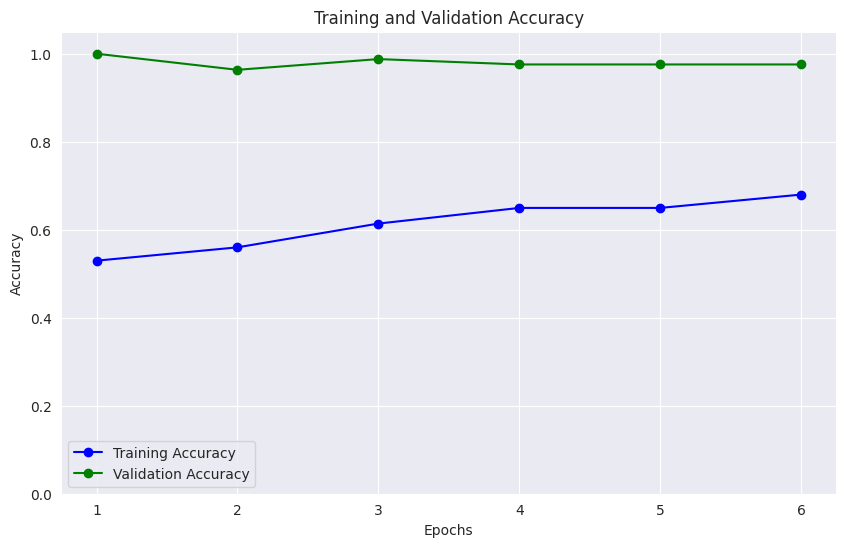


Loading best checkpoint...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating on test set...
Testing DataLoader 0: 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]

Classification Report:
              precision    recall  f1-score   support

    Non-Fire       1.00      1.00      1.00        41
        Fire       1.00      1.00      1.00        40

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



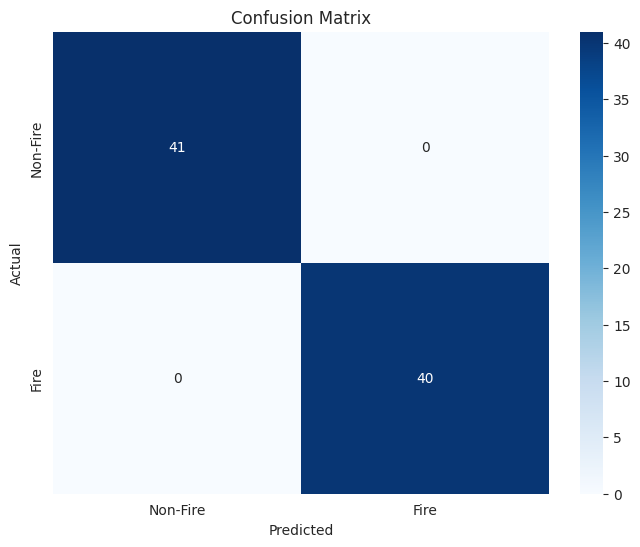

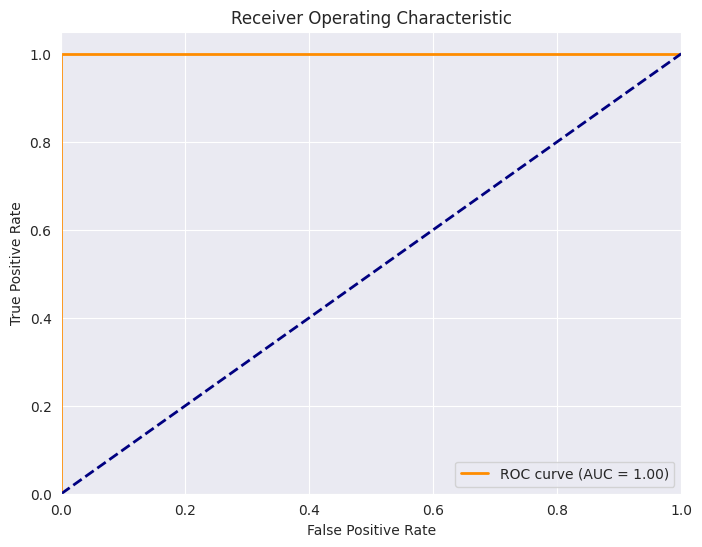

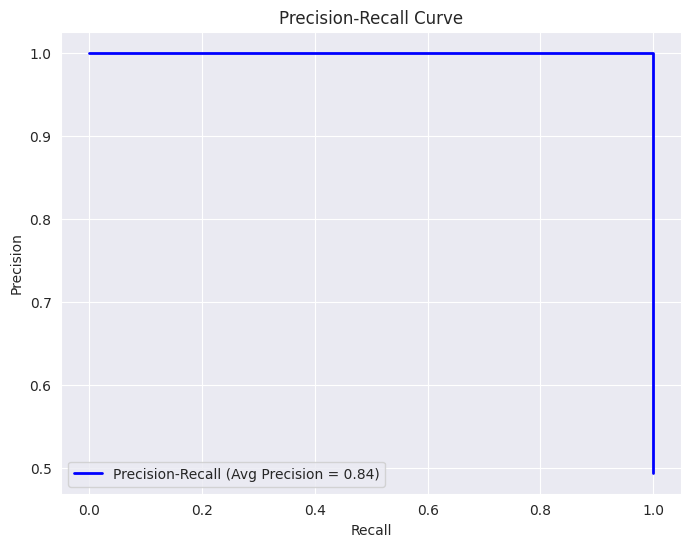

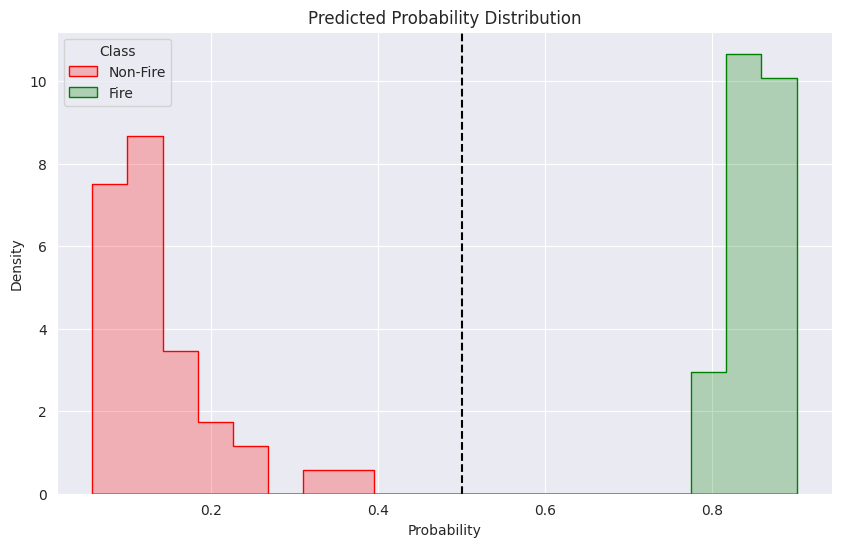

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    1.0
         test_f1                    1.0
        test_loss            0.155252143740654
     test_precision                 1.0
       test_recall                  1.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Fusion model weights saved
Fire predictor initialized


In [11]:
# Initialize feature extractors (load with trained weights)
print("Loading pretrained feature extractors...")
# Load ViT extractor from Lightning checkpoint
vit_extractor = FireFeatureExtractorViT.load_from_checkpoint("Saved_Features/ViT_fire_feature_extractor.pth")

# Initialize CNN extractor and load weights
cnn_extractor = FireFeatureExtractorCNN()
cnn_extractor.load_state_dict(
    torch.load("Saved_Features/CNN_fire_feature_extractor.pth"),
    strict=False  # Ignore classifier weights
)

# Remove classifier from CNN model
cnn_extractor.classifier = nn.Identity()  # Replace classifier with identity function

# Set both models to evaluation mode
vit_extractor.eval()
cnn_extractor.eval()
print("Feature extractors loaded and ready")

# Fusion model configuration
config = {
    "lr": 5e-4,          # Learning rate
    "hidden_dim": 768,    # Hidden layer dimension
    "dropout_rate": 0.2,  # Dropout probability
    "pos_weight": 1.0     # Class imbalance weight
}

# Train fusion model
print("\nTraining fusion model...")
fusion_model, results = train_fusion_model(
    vit_extractor,
    cnn_extractor,
    train_loader,
    val_loader,
    test_loader,
    max_epochs=20,
    config=config,
    visuals=True  # Enable advanced visualizations
)

# Save model weights
fusion_model.eval()
torch.save(fusion_model.state_dict(), "Saved_Features/fusion_model_weights.pth")
print("Fusion model weights saved")

# Initialize predictor for deployment
predictor = FirePredictor(fusion_model, vit_extractor, cnn_extractor)
print("Fire predictor initialized")

In [16]:
# Example prediction using the trained fusion model
print("\nRunning example prediction...")
# Paths to test images
vit_path = "dataset/raw/RGB/fire/00008.JPG"      # RGB image path
cnn_path = "dataset/raw/thermal/fire/00008.JPG"  # Thermal image path

# Make prediction
prediction, probability = predictor.predict(vit_path, cnn_path)

# Display results
print("\nPredicting FIRE images:")
print(f"  RGB Image: {os.path.basename(vit_path)}")
print(f"  Thermal Image: {os.path.basename(cnn_path)}")
print(f"Prediction: {prediction} (Probability: {probability:.4f})")
print(f"Interpretation: {'FIRE DETECTED' if prediction == 'Fire' else 'No fire detected'}")


Running example prediction...

Predicting FIRE images:
  RGB Image: 00008.JPG
  Thermal Image: 00008.JPG
Prediction: Fire (Probability: 0.8111)
Interpretation: FIRE DETECTED


In [15]:
# Example prediction using the trained fusion model
print("\nRunning example prediction...")
# Paths to test images
vit_path = "dataset/raw/RGB/no_fire/00052.JPG"      # RGB image path
cnn_path = "dataset/raw/thermal/no_fire/00052.JPG"  # Thermal image path

# Make prediction
prediction, probability = predictor.predict(vit_path, cnn_path)

# Display results
print("\nPredicting NON-FIRE images:")
print(f"  RGB Image: {os.path.basename(vit_path)}")
print(f"  Thermal Image: {os.path.basename(cnn_path)}")
print(f"Prediction: {prediction} (Probability: {probability:.4f})")
print(f"Interpretation: {'FIRE DETECTED' if prediction == 'Fire' else 'No fire detected'}")


Running example prediction...

Predicting NON-FIRE images:
  RGB Image: 00052.JPG
  Thermal Image: 00052.JPG
Prediction: Not Fire (Probability: 0.1490)
Interpretation: No fire detected
